Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.0157


 v = 0.00000
Iteration 10000: Position (x, y) = (0.19, 0.08), Wall Distance = 0.08 m
Iteration 20000: Position (x, y) = (0.24, 0.07), Wall Distance = 0.03 m
Iteration 30000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.02 m
Iteration 40000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.02 m
Iteration 50000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.02 m
Iteration 60000: Position (x, y) = (0.26, 0.08), Wall Distance = 0.02 m
Iteration 70000: Position (x, y) = (0.26, 0.08), Wall Distance = 0.02 m
Iteration 80000: Position (x, y) = (0.28, 0.11), Wall Distance = 0.02 m
Total simulation time: 20.41 seconds
Bumped
0.1457
0.17903329905105506


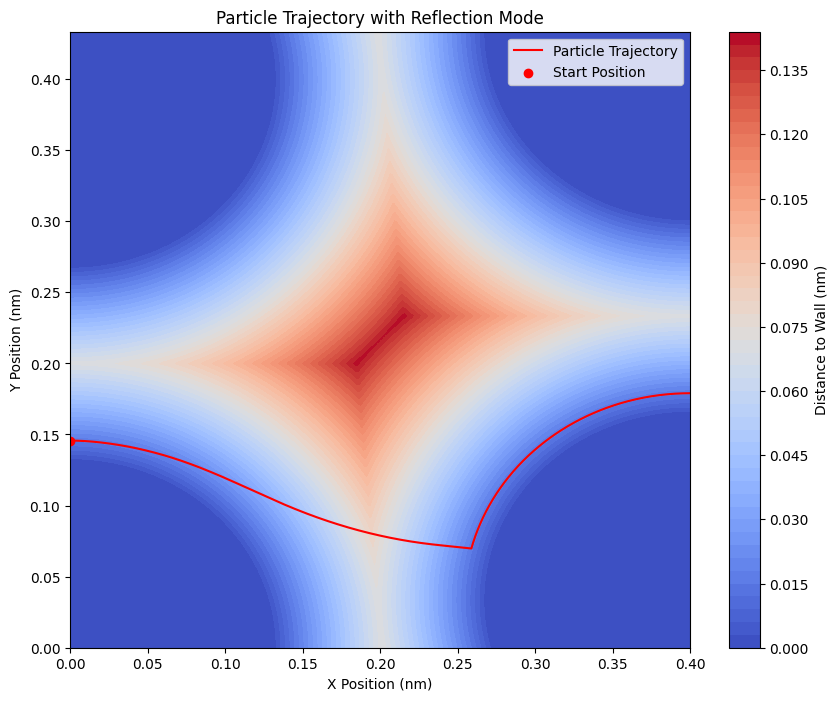

In [14]:
###### PT +FILE given + mode output  + plot included + input radius #############

##############################           ########################################


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

#/mnt/c/Users/mahir/vU_0.65_12.csv
#/mnt/c/Users/mahir/OneDrive/Desktop/Research/uioy/UPV_0.7_14
# Extract radius from the file path 
file_path = "/mnt/c/Users/mahir/OneDrive/Desktop/Research/uioy/UPVo_0.65_12.csv"
radius_match = re.search(r"UPVo_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.0001  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = 0, 0
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_traj.append(x_next)
    y_traj.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_traj[-2] > y_traj[-3]:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Particle Trajectory')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with Reflection Mode')
plt.show()


Extracted radius: 0.08000000000000002 m, n: 8


Enter the radius of the particle (in m):  0.045


Trajectory 1 Bumped at y = 0.22922593976186456
Trajectory 2 Bumped at y = 0.20775179964031276
Trajectory 3 Zigzag - stopping simulation


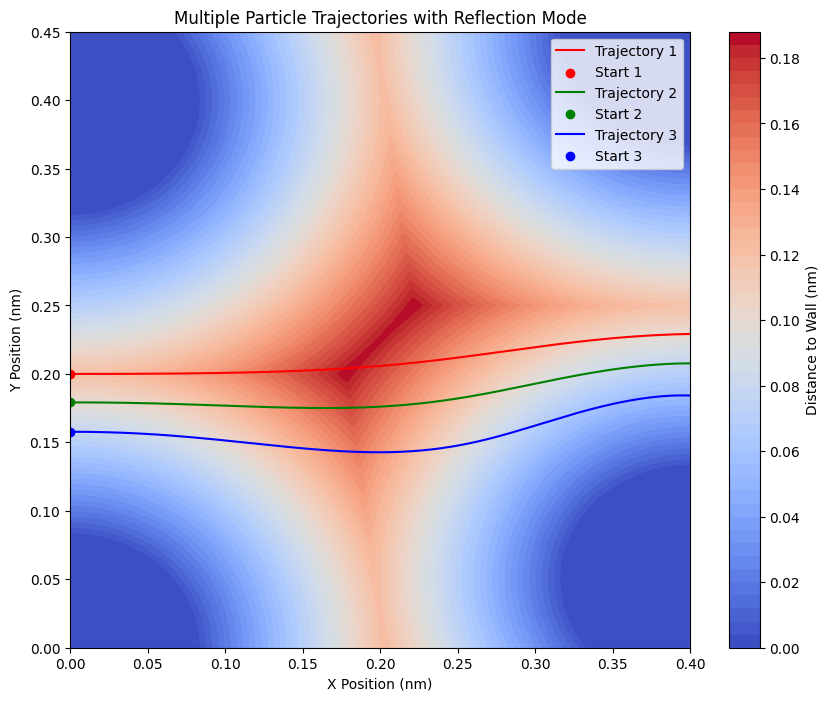

In [6]:
###### PT +FILE given + mode output  + plot included + input radius #############

##############################           ########################################


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

#"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/velocityU_0.65_12.csv"
#"/mnt/c/Users/mahir/wer_0.6_14.csv"
# Extract radius from the file path 
file_path = "/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.4_8.csv"
radius_match = re.search(r"U_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Create lists to store multiple trajectories
all_trajectories_x = []
all_trajectories_y = []

# Initial position for first trajectory
x0, y0 = 0, 0.2
current_y_start = y0

max_trajectories = 5  # Set a maximum number of trajectories
trajectory_count = 0

while trajectory_count < max_trajectories:
    # Reset trajectory lists for current run
    x_traj = [x0]
    y_traj = [y0]
    wall_distances = []
    
    # Initialize velocity for new trajectory
    u, v = 0, 0
    
    # Run trajectory simulation
    i = 0
    while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
        x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
        
        # Interpolate wall distance at the new position
        distance_to_wall = wall_distance_interp(x_next, y_next)
        wall_distances.append(distance_to_wall)
        
        # Check if particle hits the wall
        if distance_to_wall <= wall_distance_threshold:
            nx = normal_x_interp(x_next, y_next)
            ny = normal_y_interp(x_next, y_next)
            
            dot_product = u * nx + v * ny
            u = u - 2 * dot_product * nx
            v = v - 2 * dot_product * ny
            
            x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
            y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
            
            distance_to_wall = wall_distance_interp(x_next, y_next)
        else:
            u, v = velocity(x_next, y_next, u_interp, v_interp)
            
        x_traj.append(x_next)
        y_traj.append(y_next)
        
        i += 1
        if i % 10000 == 0:
            print(f"Trajectory {trajectory_count + 1}, Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f})")

    # Store completed trajectory
    all_trajectories_x.append(x_traj)
    all_trajectories_y.append(y_traj)
    
    # Check if trajectory was bumped
    if y_traj[-2] > y_traj[-3]:
        print(f"Trajectory {trajectory_count + 1} Bumped at y = {y_traj[-1]}")
        # Set up initial conditions for next trajectory
        x0 = 0
        y0 = y_traj[-2] - tilt
        current_y_start = y0
    else:
        print(f"Trajectory {trajectory_count + 1} Zigzag - stopping simulation")
        break
    
    trajectory_count += 1

# Plot all trajectories
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')

# Plot each trajectory with different colors
colors = ['r', 'g', 'b', 'y', 'm']
for idx, (x_traj, y_traj) in enumerate(zip(all_trajectories_x, all_trajectories_y)):
    plt.plot(x_traj, y_traj, f'{colors[idx]}-', 
             label=f'Trajectory {idx + 1}')
    plt.scatter([x_traj[0]], [y_traj[0]], color=colors[idx], 
                label=f'Start {idx + 1}')

plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Multiple Particle Trajectories with Reflection Mode')
plt.show()


In [4]:
len(x_traj)

52960

Enter velocity type (e.g., 'velocityU'):  velocityU


Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.005379


 v = 0.00000
Iteration 10000: Position (x, y) = (0.09, 0.11), Wall Distance = 0.01 m
Iteration 20000: Position (x, y) = (0.14, 0.08), Wall Distance = 0.04 m
Iteration 30000: Position (x, y) = (0.18, 0.06), Wall Distance = 0.06 m
Iteration 40000: Position (x, y) = (0.20, 0.04), Wall Distance = 0.07 m
Iteration 50000: Position (x, y) = (0.20, 0.03), Wall Distance = 0.07 m
Iteration 60000: Position (x, y) = (0.20, 0.02), Wall Distance = 0.07 m
Total simulation time: 14.28 seconds
Zigzag
0.135379
nan


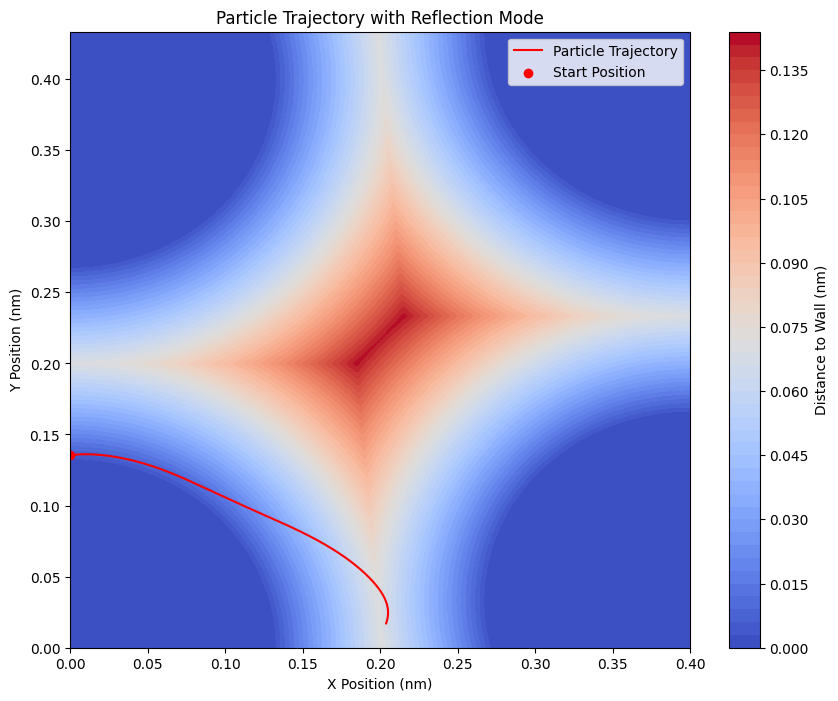

In [4]:
###### PT +FILE given + mode output  + plot included + input radius #############

##############################   MAX Iteration        ###########################

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re


velocity_type = input("Enter velocity type (e.g., 'velocityU'): ")

# Construct file path using the input
file_path = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/{velocity_type}_0.65_12.csv"
# Extract radius from the file path
radius_match = re.search(fr"{velocity_type}_([\d]+\.[\d]+)_([\d]+)", file_path) 
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
max_iterations = 300000  # Set maximum number of iterations
while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001 and i < max_iterations:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_traj.append(x_next)
    y_traj.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

if i >= max_iterations:
    print(f"Simulation stopped after reaching maximum iterations ({max_iterations})")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_traj[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Particle Trajectory')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with Reflection Mode')
plt.show()

In [ ]:
#combined
#PT+FILE+mode+plot+input radius

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re


velocity_type = input("Enter velocity type (e.g., 'velocityU'): ")

# Construct file path using the input
file_path = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/{velocity_type}_0.65_12.csv"
# Extract radius from the file path
radius_match = re.search(fr"{velocity_type}_([\d]+\.[\d]+)_([\d]+)", file_path) 
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_traj.append(x_next)
    y_traj.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_traj[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)


Enter velocity type (e.g., 'velocityU'):  velocityU


Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.01


 v = 0.00000
Iteration 10000: Position (x, y) = (0.12, 0.11), Wall Distance = 0.03 m
Iteration 20000: Position (x, y) = (0.18, 0.08), Wall Distance = 0.07 m
Iteration 30000: Position (x, y) = (0.21, 0.06), Wall Distance = 0.06 m
Iteration 40000: Position (x, y) = (0.23, 0.06), Wall Distance = 0.04 m
Iteration 50000: Position (x, y) = (0.24, 0.06), Wall Distance = 0.03 m
Iteration 60000: Position (x, y) = (0.25, 0.06), Wall Distance = 0.02 m
Iteration 70000: Position (x, y) = (0.25, 0.06), Wall Distance = 0.02 m
Iteration 80000: Position (x, y) = (0.26, 0.06), Wall Distance = 0.02 m
Iteration 90000: Position (x, y) = (0.26, 0.06), Wall Distance = 0.02 m
Iteration 100000: Position (x, y) = (0.26, 0.06), Wall Distance = 0.01 m
Iteration 110000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.01 m
Iteration 120000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.01 m
Iteration 130000: Position (x, y) = (0.26, 0.07), Wall Distance = 0.01 m
Iteration 140000: Position (x, y) = (0.26, 0.07

In [ ]:
#combined
#PT+FILE+mode+plot+input radius

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re



# Construct file path using the input
file_path = "/mnt/c/Users/mahir/wer_0.6_14.csv"
# Extract radius from the file path
radius_match = re.search(r"wer_([\d]+\.[\d]+)_([\d]+)", file_path) 
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_traj = [x0]
y_traj = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
    x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_traj.append(x_next)
    y_traj.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_traj[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)


In [11]:
#combined
#PT+FILE+mode+plot+input radius

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re


velocity_type = input("Enter velocity type (e.g., 'velocityU'): ")

# Construct file path using the input
file_path = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/{velocity_type}_0.65_12.csv"
f_p = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.65_12.csv"

# Extract radius from the file path
radius_match = re.search(fr"{velocity_type}_([\d]+\.[\d]+)_([\d]+)", file_path) 
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)
ac_fd = pd.read_csv(f_p)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = ac_fd['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_tr = [x0]
y_tr = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_tr[-1] < 0.39999 and y_tr[-1] > 0.0001:
    x_next, y_next = rk4_step(x_tr[-1], y_tr[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_tr.append(x_next)
    y_tr.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_tr[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)


Enter velocity type (e.g., 'velocityU'):  velocityU


Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.01


 v = 0.00000
Iteration 10000: Position (x, y) = (0.12, 0.11), Wall Distance = 0.03 m
Iteration 20000: Position (x, y) = (0.17, 0.08), Wall Distance = 0.06 m
Iteration 30000: Position (x, y) = (0.20, 0.06), Wall Distance = 0.07 m
Iteration 40000: Position (x, y) = (0.22, 0.05), Wall Distance = 0.05 m
Iteration 50000: Position (x, y) = (0.22, 0.04), Wall Distance = 0.05 m
Iteration 60000: Position (x, y) = (0.23, 0.03), Wall Distance = 0.04 m
Total simulation time: 17.64 seconds
Zigzag
0.14
nan


In [12]:
#combined
#PT+FILE+mode+plot+input radius

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re


velocity_type = input("Enter velocity type (e.g., 'velocityU'): ")

# Construct file path using the input
file_path = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/{velocity_type}_0.65_12.csv"
f_p = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.65_12.csv"

# Extract radius from the file path
radius_match = re.search(fr"{velocity_type}_([\d]+\.[\d]+)_([\d]+)", file_path) 
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)
ac_fd = pd.read_csv(f_p)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = ac_fd['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_t = [x0]
y_t = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_t[-1] < 0.39999 and y_t[-1] > 0.0001:
    x_next, y_next = rk4_step(x_t[-1], y_t[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_t.append(x_next)
    y_t.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_t[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)


Enter velocity type (e.g., 'velocityU'):  velocityU


Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.01


 v = -0.00000
Iteration 10000: Position (x, y) = (0.11, 0.10), Wall Distance = 0.02 m
Iteration 20000: Position (x, y) = (0.17, 0.08), Wall Distance = 0.05 m
Iteration 30000: Position (x, y) = (0.19, 0.06), Wall Distance = 0.07 m
Iteration 40000: Position (x, y) = (0.21, 0.04), Wall Distance = 0.06 m
Iteration 50000: Position (x, y) = (0.21, 0.03), Wall Distance = 0.06 m
Total simulation time: 12.67 seconds
Zigzag
0.14
nan


Enter velocity type (e.g., 'velocityU'):  U


Extracted radius: 0.13 m, n: 12


Enter the radius of the particle (in m):  0.01


 v = -0.00000
Iteration 10000: Position (x, y) = (0.11, 0.10), Wall Distance = 0.02 m
Iteration 20000: Position (x, y) = (0.16, 0.08), Wall Distance = 0.04 m
Iteration 30000: Position (x, y) = (0.18, 0.06), Wall Distance = 0.06 m
Iteration 40000: Position (x, y) = (0.19, 0.04), Wall Distance = 0.07 m
Iteration 50000: Position (x, y) = (0.20, 0.02), Wall Distance = 0.07 m
Total simulation time: 13.06 seconds
Zigzag
0.14
nan


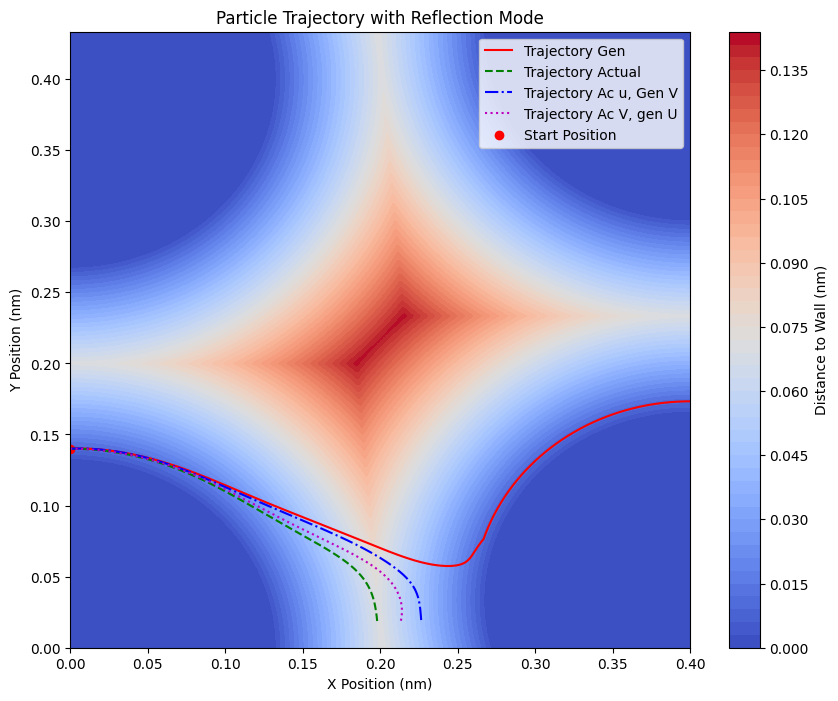

In [14]:
velocity_type = input("Enter velocity type (e.g., 'velocityU'): ")

# Construct file path using the input
file_path = f"/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/{velocity_type}_0.65_12.csv"
# Extract radius from the file path
radius_match = re.search(fr"{velocity_type}_([\d]+\.[\d]+)_([\d]+)", file_path)
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for the radius of the particle
radius_of_particle = float(input("Enter the radius of the particle (in m): "))
y_s = radius + radius_of_particle
wall_distance_threshold = radius_of_particle  # Set the wall distance threshold


# Create a grid to compute distances
x_range = np.linspace(0, 0.4, 400)
y_range = np.linspace(0, 0.4+tilt, 400)
X, Y = np.meshgrid(x_range, y_range)

# Calculate the distance from each point in the grid to the nearest circular post
distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity

for cx, cy in centers:
    distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
    distances = np.minimum(distances, distance_to_post)  # Take the minimum distance

# Set negative distances to zero
distances = np.maximum(distances, 0)

# Calculate the gradient of the wall distance function
dy, dx = np.gradient(distances, y_range, x_range)

# Calculate the magnitude of the gradient (surface normal)
gradient_magnitude = np.sqrt(dx**2 + dy**2)

# Initialize normal_x and normal_y with zeros
normal_x = np.zeros_like(dx)
normal_y = np.zeros_like(dy)

# Avoid division by zero by normalizing only where gradient_magnitude is not zero
non_zero_magnitude = gradient_magnitude > 0
normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]

# Create LinearNDInterpolators for wall distance and normals
wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)

# Load the particle velocity data
velocity_field_data = pd.read_csv(file_path)

x = velocity_field_data['x'].values
y = velocity_field_data['y'].values
u = velocity_field_data['u'].values
v = velocity_field_data['v'].values

# Normalize the velocity components
maxu = np.max(np.abs(u))
maxv = np.max(np.abs(v))
max_vel = max(maxu, maxv)

# Create LinearNDInterpolator for U and V fields
u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)

def velocity(x, y, u_interp, v_interp):
    """Interpolate velocity at the particle's position."""
    u = u_interp(x, y)
    v = v_interp(x, y)
    return u, v

def rk4_step(x, y, dt, u, v):
    """Calculate the next position of the particle using RK4 with provided velocity components."""
    # k1
    k1x = dt * u
    k1y = dt * v

    # k2
    u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
    k2x = dt * u2
    k2y = dt * v2

    # k3
    u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
    k3x = dt * u3
    k3y = dt * v3

    # k4
    u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
    k4x = dt * u4
    k4y = dt * v4

    # Combine increments to get the next position
    x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
    y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6

    return x_next, y_next

# Initial position of the particle
x0, y0 = 0, y_s  # Starting at x=0, y=142.5
dt = 0.00005  # Time step

# Lists to store the particle's trajectory and wall distance
x_tra = [x0]
y_tra = [y0]
wall_distances = []  # To store the wall distance after each iteration

# Start timer for simulation
start_time = time.time()

# Initialize the initial velocity
u, v = velocity(x0, y0, u_interp, v_interp)
print(f" v = {v:.5f}")

# Simulate the particle trajectory with reflection mode
i = 0
while x_tra[-1] < 0.39999 and y_tra[-1] > 0.0001:
    x_next, y_next = rk4_step(x_tra[-1], y_tra[-1], dt, u, v)
    
    # Interpolate wall distance at the new position
    distance_to_wall = wall_distance_interp(x_next, y_next)
    wall_distances.append(distance_to_wall)  # Append the wall distance to the list
    
    # Check if particle hits the wall (distance <= wall_distance_threshold)
    if distance_to_wall <= wall_distance_threshold:
        # Get the normal vector at the point of collision
        nx = normal_x_interp(x_next, y_next)
        ny = normal_y_interp(x_next, y_next)
        
        # Reflect the velocity according to the COMSOL-style bounce model
        dot_product = u * nx + v * ny
        u = u - 2 * dot_product * nx
        v = v - 2 * dot_product * ny
        
        # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
        x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
        y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
        
        # Update distance to ensure it's precisely at the threshold after moving
        distance_to_wall = wall_distance_interp(x_next, y_next)
    else:
        u, v = velocity(x_next, y_next, u_interp, v_interp)
        
    #if x_next > 0.3995:
        #print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), u = {u:.5f}, v = {v:.5f} ")

    x_tra.append(x_next)
    y_tra.append(y_next)

    i += 1
    if i % 10000 == 0:
        print(f"Iteration {i}: Position (x, y) = ({x_next:.2f}, {y_next:.2f}), Wall Distance = {distance_to_wall:.2f} m")

# End timer for simulation
print(f"Total simulation time: {time.time() - start_time:.2f} seconds")

if y_tra[-3] > y_s:
    print("Bumped")
    print(y_s)
    print(y_next)
else:
    print("Zigzag")
    print(y_s)
    print(y_next)

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, distances, levels=50, cmap='coolwarm')
plt.colorbar(label='Distance to Wall (nm)')
plt.plot(x_traj, y_traj, 'r-', label='Trajectory Gen')
plt.plot(x_tra, y_tra, 'g--', label='Trajectory Actual')
plt.plot(x_tr, y_tr, 'b-.', label='Trajectory Ac u, Gen V')
plt.plot(x_t, y_t, 'm:', label='Trajectory Ac V, gen U')
plt.scatter([x0], [y0], color='red', label='Start Position')
plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.legend()
plt.title('Particle Trajectory with Reflection Mode')
plt.show()

In [14]:
# critical diameter prediction code for #### ACTUAL Result ####
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

##### Extract radius from the file path #####
file_path = "/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.25_8.csv"
radius_match = re.search(r"U_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2  # Extract and multiply by 0.4
    n = int(radius_match.group(2))  # Extract n value
    print(f"Extracted radius: {radius} m, n: {n}")
else:
    raise ValueError("Could not determine radius from file name.")
##### CSV value extraction end ####

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]


# User input for the range of particle radius values
min_radius = float(input("Enter the minimum radius of the particle (in m): "))
max_radius = float(input("Enter the maximum radius of the particle (in m): "))
num_values = int(input("Enter the number of values to generate in this range: "))

radius_values = np.linspace(min_radius, max_radius, num_values)

# Store results in a list
result_A = []

for radius_of_particle in radius_values:
    y_s = radius + radius_of_particle
    wall_distance_threshold = radius_of_particle  # Set the wall distance threshold

    # Create a grid to compute distances
    x_range = np.linspace(0, 0.4, 400)
    y_range = np.linspace(0, 0.4+tilt, 400)
    X, Y = np.meshgrid(x_range, y_range)
    
    # Calculate the distance from each point in the grid to the nearest circular post
    distances = np.full_like(X, np.inf, dtype=float)  # Initialize with infinity
    
    for cx, cy in centers:
        distance_to_post = np.sqrt((X - cx)**2 + (Y - cy)**2) - radius
        distances = np.minimum(distances, distance_to_post)  # Take the minimum distance
    
    # Set negative distances to zero
    distances = np.maximum(distances, 0)
    
    # Calculate the gradient of the wall distance function
    dy, dx = np.gradient(distances, y_range, x_range)
    
    # Calculate the magnitude of the gradient (surface normal)
    gradient_magnitude = np.sqrt(dx**2 + dy**2)
    
    # Initialize normal_x and normal_y with zeros
    normal_x = np.zeros_like(dx)
    normal_y = np.zeros_like(dy)
    
    # Avoid division by zero by normalizing only where gradient_magnitude is not zero
    non_zero_magnitude = gradient_magnitude > 0
    normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    
    # Create LinearNDInterpolators for wall distance and normals
    wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
    normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
    normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)
    
    # Load the particle velocity data
    velocity_field_data = pd.read_csv(file_path)
    
    x = velocity_field_data['x'].values
    y = velocity_field_data['y'].values
    u = velocity_field_data['u'].values
    v = velocity_field_data['v'].values
    
    # Normalize the velocity components
    maxu = np.max(np.abs(u))
    maxv = np.max(np.abs(v))
    max_vel = max(maxu, maxv)
    
    # Create LinearNDInterpolator for U and V fields
    u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)  # Normalize during interpolation setup
    v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)
    
    def velocity(x, y, u_interp, v_interp):
        """Interpolate velocity at the particle's position."""
        u = u_interp(x, y)
        v = v_interp(x, y)
        return u, v
    
    def rk4_step(x, y, dt, u, v):
        """Calculate the next position of the particle using RK4 with provided velocity components."""
        # k1
        k1x = dt * u
        k1y = dt * v
    
        # k2
        u2, v2 = velocity(x + k1x / 2, y + k1y / 2, u_interp, v_interp)
        k2x = dt * u2
        k2y = dt * v2
    
        # k3
        u3, v3 = velocity(x + k2x / 2, y + k2y / 2, u_interp, v_interp)
        k3x = dt * u3
        k3y = dt * v3
    
        # k4
        u4, v4 = velocity(x + k3x, y + k3y, u_interp, v_interp)
        k4x = dt * u4
        k4y = dt * v4
    
        # Combine increments to get the next position
        x_next = x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
        y_next = y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
    
        return x_next, y_next
    
    # Initial position of the particle
    x0, y0 = 0, y_s  # Starting at x=0, y=142.5
    dt = 0.00005  # Time step
    
    # Lists to store the particle's trajectory and wall distance
    x_traj = [x0]
    y_traj = [y0]
    wall_distances = []  # To store the wall distance after each iteration
    
    # Start timer for simulation
    start_time = time.time()
    
    # Initialize the initial velocity
    u, v = velocity(x0, y0, u_interp, v_interp)
    
    # Simulate the particle trajectory with reflection mode
    i = 0
    while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
        x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
        
        # Interpolate wall distance at the new position
        distance_to_wall = wall_distance_interp(x_next, y_next)
        wall_distances.append(distance_to_wall)  # Append the wall distance to the list
        
        # Check if particle hits the wall (distance <= wall_distance_threshold)
        if distance_to_wall <= wall_distance_threshold:
            # Get the normal vector at the point of collision
            nx = normal_x_interp(x_next, y_next)
            ny = normal_y_interp(x_next, y_next)
            
            # Reflect the velocity according to the COMSOL-style bounce model
            dot_product = u * nx + v * ny
            u = u - 2 * dot_product * nx
            v = v - 2 * dot_product * ny
            
            # Move the particle to exactly wall_distance_threshold away from the wall along the normal direction
            x_next = x_next + (wall_distance_threshold - distance_to_wall) * nx
            y_next = y_next + (wall_distance_threshold - distance_to_wall) * ny
            
            # Update distance to ensure it's precisely at the threshold after moving
            distance_to_wall = wall_distance_interp(x_next, y_next)
        else:
            u, v = velocity(x_next, y_next, u_interp, v_interp)
            
        
        x_traj.append(x_next)
        y_traj.append(y_next)
    
    
    
    # Determine the mode based on final position
    if y_traj[-3] > y_s:
        result_text = f"Particle radius: {radius_of_particle:.6f} m, Bumped mode"
    else:
        result_text = f"Particle radius: {radius_of_particle:.6f} m, Zigzag Mode"
    
    result_A.append(result_text)

Extracted radius: 0.05 m, n: 8


Enter the minimum radius of the particle (in m):  0.055
Enter the maximum radius of the particle (in m):  0.06
Enter the number of values to generate in this range:  11


In [15]:
result_A

['Particle radius: 0.055000 m, Zigzag Mode',
 'Particle radius: 0.055500 m, Zigzag Mode',
 'Particle radius: 0.056000 m, Zigzag Mode',
 'Particle radius: 0.056500 m, Zigzag Mode',
 'Particle radius: 0.057000 m, Zigzag Mode',
 'Particle radius: 0.057500 m, Zigzag Mode',
 'Particle radius: 0.058000 m, Zigzag Mode',
 'Particle radius: 0.058500 m, Bumped mode',
 'Particle radius: 0.059000 m, Bumped mode',
 'Particle radius: 0.059500 m, Bumped mode',
 'Particle radius: 0.060000 m, Bumped mode']

In [18]:
#root finding with tolerance
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

# Extract radius from the file path 
file_path = "/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.25_3.csv"
radius_match = re.search(r"U_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2
    n = int(radius_match.group(2))
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for upper and lower bounds
lower_radius = float(input("Enter the lower radius of the particle (in m): "))
upper_radius = float(input("Enter the upper radius of the particle (in m): "))

def compute_result(radius_of_particle):
    y_s = radius + radius_of_particle
    wall_distance_threshold = radius_of_particle
    
    x_range = np.linspace(0, 0.4, 400)
    y_range = np.linspace(0, 0.4 + tilt, 400)
    X, Y = np.meshgrid(x_range, y_range)
    
    distances = np.full_like(X, np.inf, dtype=float)
    for cx, cy in centers:
        distance_to_post = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2) - radius
        distances = np.minimum(distances, distance_to_post)
    distances = np.maximum(distances, 0)
    
    dy, dx = np.gradient(distances, y_range, x_range)
    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    
    normal_x = np.zeros_like(dx)
    normal_y = np.zeros_like(dy)
    non_zero_magnitude = gradient_magnitude > 0
    normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    
    wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
    normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
    normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)
    
    velocity_field_data = pd.read_csv(file_path)
    x = velocity_field_data['x'].values
    y = velocity_field_data['y'].values
    u = velocity_field_data['u'].values
    v = velocity_field_data['v'].values
    
    max_vel = max(np.max(np.abs(u)), np.max(np.abs(v)))
    u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)
    v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)
    
    def velocity(x, y):
        return u_interp(x, y), v_interp(x, y)
    
    def rk4_step(x, y, dt, u, v):
        k1x = dt * u
        k1y = dt * v
        u2, v2 = velocity(x + k1x / 2, y + k1y / 2)
        k2x = dt * u2
        k2y = dt * v2
        u3, v3 = velocity(x + k2x / 2, y + k2y / 2)
        k3x = dt * u3
        k3y = dt * v3
        u4, v4 = velocity(x + k3x, y + k3y)
        k4x = dt * u4
        k4y = dt * v4
        return x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6, y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
    
    x0, y0 = 0, y_s
    dt = 0.00005
    x_traj, y_traj = [x0], [y0]
    u, v = velocity(x0, y0)
    
    while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
        x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
        distance_to_wall = wall_distance_interp(x_next, y_next)
        if distance_to_wall <= wall_distance_threshold:
            nx, ny = normal_x_interp(x_next, y_next), normal_y_interp(x_next, y_next)
            dot_product = u * nx + v * ny
            u = u - 2 * dot_product * nx
            v = v - 2 * dot_product * ny
            x_next += (wall_distance_threshold - distance_to_wall) * nx
            y_next += (wall_distance_threshold - distance_to_wall) * ny
        else:
            u, v = velocity(x_next, y_next)
        x_traj.append(x_next)
        y_traj.append(y_next)
    
    return 1 if y_traj[-3] > y_s else -1

# Binary search method to find critical radius
tolerance = 0.0001
while abs(upper_radius - lower_radius) > tolerance:
    mid_radius = (upper_radius + lower_radius) / 2
    mid_result = compute_result(mid_radius)
    print(mid_result)
    print(mid_radius)
    if mid_result == -1:
        lower_radius = mid_radius
    else:
        upper_radius = mid_radius

print(f"Critical radius range: Lower = {lower_radius:.5f} m, Upper = {upper_radius:.5f} m")


Enter the lower radius of the particle (in m):  0.11
Enter the upper radius of the particle (in m):  0.12


1
0.11499999999999999
-1
0.11249999999999999
1
0.11374999999999999
1
0.11312499999999999
1
0.11281249999999998
1
0.11265624999999999
-1
0.11257812499999999
Critical radius range: Lower = 0.11258 m, Upper = 0.11266 m


In [52]:
#### critical dia for DNN   #####
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

# Extract radius from the file path 
file_path = "/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/velocity_0.7_14.csv"
radius_match = re.search(r"velocity_([\d]+\.[\d]+)_([\d]+)", file_path)  
if radius_match:
    radius = float(radius_match.group(1)) * 0.2
    n = int(radius_match.group(2))
else:
    raise ValueError("Could not determine radius from file name.")

tilt = 0.4 / n
centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]

# User input for upper and lower bounds
lower_radius = float(input("Enter the lower radius of the particle (in m): "))
upper_radius = float(input("Enter the upper radius of the particle (in m): "))

def compute_result(radius_of_particle):
    y_s = radius + radius_of_particle
    wall_distance_threshold = radius_of_particle
    
    x_range = np.linspace(0, 0.4, 400)
    y_range = np.linspace(0, 0.4 + tilt, 400)
    X, Y = np.meshgrid(x_range, y_range)
    
    distances = np.full_like(X, np.inf, dtype=float)
    for cx, cy in centers:
        distance_to_post = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2) - radius
        distances = np.minimum(distances, distance_to_post)
    distances = np.maximum(distances, 0)
    
    dy, dx = np.gradient(distances, y_range, x_range)
    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    
    normal_x = np.zeros_like(dx)
    normal_y = np.zeros_like(dy)
    non_zero_magnitude = gradient_magnitude > 0
    normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
    
    wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
    normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
    normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)
    
    velocity_field_data = pd.read_csv(file_path)
    x = velocity_field_data['x'].values
    y = velocity_field_data['y'].values
    u = velocity_field_data['u'].values
    v = velocity_field_data['v'].values
    
    max_vel = max(np.max(np.abs(u)), np.max(np.abs(v)))
    u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)
    v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)
    
    def velocity(x, y):
        return u_interp(x, y), v_interp(x, y)
    
    def rk4_step(x, y, dt, u, v):
        k1x = dt * u
        k1y = dt * v
        u2, v2 = velocity(x + k1x / 2, y + k1y / 2)
        k2x = dt * u2
        k2y = dt * v2
        u3, v3 = velocity(x + k2x / 2, y + k2y / 2)
        k3x = dt * u3
        k3y = dt * v3
        u4, v4 = velocity(x + k3x, y + k3y)
        k4x = dt * u4
        k4y = dt * v4
        return x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6, y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
    
    x0, y0 = 0, y_s
    dt = 0.00005
    x_traj, y_traj = [x0], [y0]
    u, v = velocity(x0, y0)
    
    while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
        x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
        distance_to_wall = wall_distance_interp(x_next, y_next)
        if distance_to_wall <= wall_distance_threshold:
            nx, ny = normal_x_interp(x_next, y_next), normal_y_interp(x_next, y_next)
            dot_product = u * nx + v * ny
            u = u - 2 * dot_product * nx
            v = v - 2 * dot_product * ny
            x_next += (wall_distance_threshold - distance_to_wall) * nx
            y_next += (wall_distance_threshold - distance_to_wall) * ny
        else:
            u, v = velocity(x_next, y_next)
        x_traj.append(x_next)
        y_traj.append(y_next)
    
    return 1 if y_traj[-3] > y_s else -1

# Binary search method to find critical radius
tolerance = 0.0001
while abs(upper_radius - lower_radius) > tolerance:
    mid_radius = (upper_radius + lower_radius) / 2
    mid_result = compute_result(mid_radius)
    print(mid_result)
    print(mid_radius)
    if mid_result == -1:
        lower_radius = mid_radius
    else:
        upper_radius = mid_radius

print(f"Critical radius range: Lower = {lower_radius:.5f} m, Upper = {upper_radius:.5f} m")


Enter the lower radius of the particle (in m):  0.066
Enter the upper radius of the particle (in m):  0.075


-1
0.07050000000000001
1
0.07275000000000001
1
0.07162500000000001
-1
0.0710625
1
0.07134375000000001
-1
0.071203125
1
0.07127343750000001
Critical radius range: Lower = 0.07120 m, Upper = 0.07127 m


In [2]:
#Gen-1
def critical_diameter(file_path, lower_radius, upper_radius):
    # Extract radius from the file path 
    radius_match = re.search(r"U_([\d]+\.[\d]+)_([\d]+)", file_path)  
    if radius_match:
        radius = float(radius_match.group(1)) * 0.2
        n = int(radius_match.group(2))
    else:
        raise ValueError("Could not determine radius from file name.")
    
    tilt = 0.4 / n
    centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]
    
    # User input for upper and lower bounds
    #lower_radius = float(input("Enter the lower radius of the particle (in m): "))
    #upper_radius = float(input("Enter the upper radius of the particle (in m): "))
    
    def compute_result(radius_of_particle):
        y_s = radius + radius_of_particle
        wall_distance_threshold = radius_of_particle
        
        x_range = np.linspace(0, 0.4, 400)
        y_range = np.linspace(0, 0.4 + tilt, 400)
        X, Y = np.meshgrid(x_range, y_range)
        
        distances = np.full_like(X, np.inf, dtype=float)
        for cx, cy in centers:
            distance_to_post = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2) - radius
            distances = np.minimum(distances, distance_to_post)
        distances = np.maximum(distances, 0)
        
        dy, dx = np.gradient(distances, y_range, x_range)
        gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
        
        normal_x = np.zeros_like(dx)
        normal_y = np.zeros_like(dy)
        non_zero_magnitude = gradient_magnitude > 0
        normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
        normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
        
        wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
        normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
        normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)
        
        velocity_field_data = pd.read_csv(file_path)
        x = velocity_field_data['x'].values
        y = velocity_field_data['y'].values
        u = velocity_field_data['u'].values
        v = velocity_field_data['v'].values
        
        max_vel = max(np.max(np.abs(u)), np.max(np.abs(v)))
        u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)
        v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)
        
        def velocity(x, y):
            return u_interp(x, y), v_interp(x, y)
        
        def rk4_step(x, y, dt, u, v):
            k1x = dt * u
            k1y = dt * v
            u2, v2 = velocity(x + k1x / 2, y + k1y / 2)
            k2x = dt * u2
            k2y = dt * v2
            u3, v3 = velocity(x + k2x / 2, y + k2y / 2)
            k3x = dt * u3
            k3y = dt * v3
            u4, v4 = velocity(x + k3x, y + k3y)
            k4x = dt * u4
            k4y = dt * v4
            return x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6, y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
        
        x0, y0 = 0, y_s
        dt = 0.00005
        x_traj, y_traj = [x0], [y0]
        u, v = velocity(x0, y0)
        
        while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001:
            x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
            distance_to_wall = wall_distance_interp(x_next, y_next)
            if distance_to_wall <= wall_distance_threshold:
                nx, ny = normal_x_interp(x_next, y_next), normal_y_interp(x_next, y_next)
                dot_product = u * nx + v * ny
                u = u - 2 * dot_product * nx
                v = v - 2 * dot_product * ny
                x_next += (wall_distance_threshold - distance_to_wall) * nx
                y_next += (wall_distance_threshold - distance_to_wall) * ny
            else:
                u, v = velocity(x_next, y_next)
            x_traj.append(x_next)
            y_traj.append(y_next)
        
        return 1 if y_traj[-3] > y_s else -1
    
    # Binary search method to find critical radius
    tolerance = 0.0001
    while abs(upper_radius - lower_radius) > tolerance:
        mid_radius = (upper_radius + lower_radius) / 2
        mid_result = compute_result(mid_radius)
        print(mid_result)
        if mid_result == -1:
            lower_radius = mid_radius
        else:
            upper_radius = mid_radius
    
    print(f"Critical radius range for {float(radius_match.group(1)):.1f} and {n}: Lower = {lower_radius:.5f} m, Upper = {upper_radius:.5f} m")

In [ ]:
#Gen-1, run code
file_paths = [
    f'/mnt/c/Users/mahir/OneDrive/Desktop/Research/New folder/U_0.55_{i}.csv'
    for i in range(10, 15)
]

lower_radius = float(input("Enter the lower radius of the particle (in m): "))
upper_radius = float(input("Enter the upper radius of the particle (in m): "))
for file_path in file_paths:
    try:
        critical_diameter(file_path, lower_radius, upper_radius)
    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

In [9]:
#Gen-2, run code
file_paths = [
    f'/mnt/c/Users/mahir/OneDrive/Desktop/Research/uioy/UPV_{velocity}_{i}.csv'
    for velocity in [0.7]
    for i in [14]
]
results = []
lower_radius = float(input("Enter the lower radius of the particle (in m): "))
upper_radius = float(input("Enter the upper radius of the particle (in m): "))

if lower_radius > upper_radius:
    print("Error: Lower radius cannot be greater than upper radius.")
    raise ValueError("Lower radius cannot be greater than upper radius.")

for file_path in file_paths:
    try:
        lw, uw, iteration, tm = critical_diameter(file_path, lower_radius, upper_radius)
        velocity, i = re.search(r"UPV_([\d]+\.[\d]+)_(\d+)", file_path).groups()
        results.append([float(velocity), int(i), uw, lw])
    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

with open('resultsrtyuio.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Velocity', 'i', 'Upper Width', 'lower Width'])
    writer.writerows(results)

print("Done!")

Enter the lower radius of the particle (in m):  0.005
Enter the upper radius of the particle (in m):  0.025


Iteration count for radius 0.015000000000000001: 22800 in 11.79 seconds
Iteration count for radius 0.01: 50381 in 18.71 seconds
Iteration count for radius 0.0125: 34642 in 14.40 seconds
Iteration count for radius 0.01125: 62483 in 22.25 seconds
Iteration count for radius 0.010624999999999999: 64904 in 20.14 seconds
Iteration count for radius 0.0109375: 93765 in 27.00 seconds
Iteration count for radius 0.01109375: 90123 in 25.41 seconds
Iteration count for radius 0.011015625: 114117 in 30.16 seconds
Critical radius range for 0.70 and 14: Lower = 0.01102 m, Upper = 0.01109 m


NameError: name 'csv' is not defined

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator, griddata
import pandas as pd
import time
import re

In [8]:
#Gen-2(time, iteration, csv file)
import re
import numpy as np
import pandas as pd
from scipy.interpolate import LinearNDInterpolator

def critical_diameter(file_path, lower_radius, upper_radius):
    # Extract radius from the file path 
    radius_match = re.search(r"UPV_([\d]+\.[\d]+)_([\d]+)", file_path)  
    if radius_match:
        radius = float(radius_match.group(1)) * 0.2
        n = int(radius_match.group(2))
    else:
        raise ValueError("Could not determine radius from file name.")
    
    tilt = 0.4 / n
    centers = [(0, 0), (0, 0.400), (0.400, tilt), (0.400, 0.400 + tilt)]
    
    def compute_result(radius_of_particle):
        y_s = radius + radius_of_particle
        wall_distance_threshold = radius_of_particle

        # Start timer for simulation
        start_time = time.time()
        
        x_range = np.linspace(0, 0.4, 400)
        y_range = np.linspace(0, 0.4 + tilt, 400)
        X, Y = np.meshgrid(x_range, y_range)
        
        distances = np.full_like(X, np.inf, dtype=float)
        for cx, cy in centers:
            distance_to_post = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2) - radius
            distances = np.minimum(distances, distance_to_post)
        distances = np.maximum(distances, 0)
        
        dy, dx = np.gradient(distances, y_range, x_range)
        gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
        
        normal_x = np.zeros_like(dx)
        normal_y = np.zeros_like(dy)
        non_zero_magnitude = gradient_magnitude > 0
        normal_x[non_zero_magnitude] = dx[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
        normal_y[non_zero_magnitude] = dy[non_zero_magnitude] / gradient_magnitude[non_zero_magnitude]
        
        wall_distance_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), distances.ravel(), fill_value=np.inf)
        normal_x_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_x.ravel(), fill_value=0)
        normal_y_interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), normal_y.ravel(), fill_value=0)
        
        velocity_field_data = pd.read_csv(file_path)
        x = velocity_field_data['x'].values
        y = velocity_field_data['y'].values
        u = velocity_field_data['u'].values
        v = velocity_field_data['v'].values
        
        max_vel = max(np.max(np.abs(u)), np.max(np.abs(v)))
        u_interp = LinearNDInterpolator(list(zip(x, y)), u / max_vel)
        v_interp = LinearNDInterpolator(list(zip(x, y)), v / max_vel)
        
        def velocity(x, y):
            return u_interp(x, y), v_interp(x, y)
        
        def rk4_step(x, y, dt, u, v):
            k1x = dt * u
            k1y = dt * v
            u2, v2 = velocity(x + k1x / 2, y + k1y / 2)
            k2x = dt * u2
            k2y = dt * v2
            u3, v3 = velocity(x + k2x / 2, y + k2y / 2)
            k3x = dt * u3
            k3y = dt * v3
            u4, v4 = velocity(x + k3x, y + k3y)
            k4x = dt * u4
            k4y = dt * v4
            return x + (k1x + 2 * k2x + 2 * k3x + k4x) / 6, y + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
        
        x0, y0 = 0, y_s
        dt = 0.0001
        x_traj, y_traj = [x0], [y0]
        u, v = velocity(x0, y0)
        
        max_iterations = 300000  # Set a maximum number of iterations
        iteration_count = 0
        
        while x_traj[-1] < 0.39999 and y_traj[-1] > 0.0001 and iteration_count < max_iterations:
            x_next, y_next = rk4_step(x_traj[-1], y_traj[-1], dt, u, v)
            distance_to_wall = wall_distance_interp(x_next, y_next)
            if distance_to_wall <= wall_distance_threshold:
                nx, ny = normal_x_interp(x_next, y_next), normal_y_interp(x_next, y_next)
                dot_product = u * nx + v * ny
                u = u - 2 * dot_product * nx
                v = v - 2 * dot_product * ny
                x_next += (wall_distance_threshold - distance_to_wall) * nx
                y_next += (wall_distance_threshold - distance_to_wall) * ny
            else:
                u, v = velocity(x_next, y_next)
            x_traj.append(x_next)
            y_traj.append(y_next)
            iteration_count += 1


        tm = time.time() - start_time

        return (1 if y_traj[-3] > y_s else -1), iteration_count, tm
    
    # Binary search method to find critical radius
    tolerance = 0.0001
    while abs(upper_radius - lower_radius) > tolerance:
        mid_radius = (upper_radius + lower_radius) / 2
        mid_result, iteration_count, tm = compute_result(mid_radius)
        print(f"Iteration count for radius {mid_radius}: {iteration_count} in {tm:.2f} seconds")
        if mid_result == -1:
            lower_radius = mid_radius
        else:
            upper_radius = mid_radius
    
    print(f"Critical radius range for {float(radius_match.group(1)):.2f} and {n}: Lower = {lower_radius:.5f} m, Upper = {upper_radius:.5f} m")

    return lower_radius, upper_radius, iteration_count, tm